<a href="https://colab.research.google.com/github/mariscalromeroalejandro/notebooks/blob/main/finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import yfinance as yf
import pandas as pd

In [58]:
tickers = [
    'JPM', 'GS', 'MS',
    'BAC',  # Bank of America
    'C',    # Citigroup
    'WFC',  # Wells Fargo
    'BLK',  # BlackRock
    'SCHW', # Charles Schwab
    'BX',   # Blackstone
    'KKR',  # KKR
    'APO',  # Apollo Global Management
    'AIG',  # American International Group
    'MET',  # MetLife
    'COF',  # Capital One
    'USB',  # U.S. Bancorp
    'PNC',  # PNC Financial
    'TFC',  # Truist Financial
    'SPGI'  # S&P Global
]
# {ticker -> DataFrame}
data = { ticker: yf.download(ticker, period = '5y', auto_adjust=False) for ticker in tickers }

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [59]:
for ticker in tickers:
  print(f"\n{ticker}:\n", data[ticker].head())
  print(f"{ticker} info:")
  print(data[ticker].info())
  print("Missing values: \n", data[ticker].isna().sum())


JPM:
 Price        Adj Close       Close        High         Low        Open  \
Ticker             JPM         JPM         JPM         JPM         JPM   
Date                                                                     
2021-01-15  122.090073  138.639999  141.649994  137.009995  137.429993   
2021-01-19  121.561699  138.039993  140.699997  137.820007  139.860001   
2021-01-20  119.738831  135.970001  138.169998  135.440002  137.820007   
2021-01-21  118.734871  134.830002  136.160004  134.320007  135.690002   
2021-01-22  117.819023  133.789993  134.399994  132.199997  132.690002   

Price         Volume  
Ticker           JPM  
Date                  
2021-01-15  27881000  
2021-01-19  19843800  
2021-01-20  16028800  
2021-01-21  13411700  
2021-01-22  12933200  
JPM info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2021-01-15 to 2026-01-14
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            ------------

In [60]:
import numpy as np

# Store dataframes per ticket
metrics = {}

for ticker in tickers:
  df = data[ticker].copy()
  volume = df['Volume'].iloc[:, 0]

  # how much did the price change compared to yesterday
  # yesterday: 100, today: 102 -> (102-100) / 100 = 2%
  df['returns'] = df['Adj Close'].pct_change()

  # how unstable has this stock been over last month (20 trading days)
  # rolling windows creates a sliding buffer
  # std: standard deviation
  df['volatility'] = df['returns'].rolling(window=20).std()

  # is today's volatility high or low compared to itself?
  # 1 -> more than usual, <1 calmer than usual
  df['volatility_relative'] = df['volatility'] / df['volatility'].mean()

  # has the stock been going up (>0) or down (<0) over last week
  # direction, not speed
  df['momentum'] = df['Adj Close'].diff(5)

  # price moving with conviction??
  # big move + high vol (high participation) = strong signal
  # big move + low vol = possibly fake
  df['momentum_vol_adj'] = df['momentum'] * volume / volume.mean()
  # O(1) average lookup
  metrics[ticker] = df

/tmp/ipython-input-2882518455.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


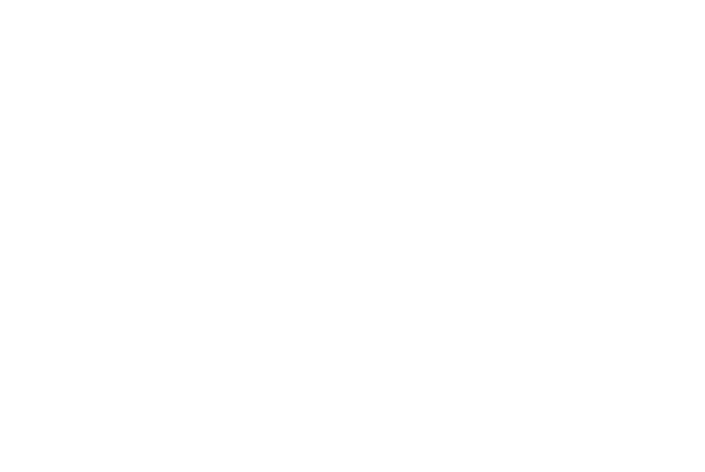

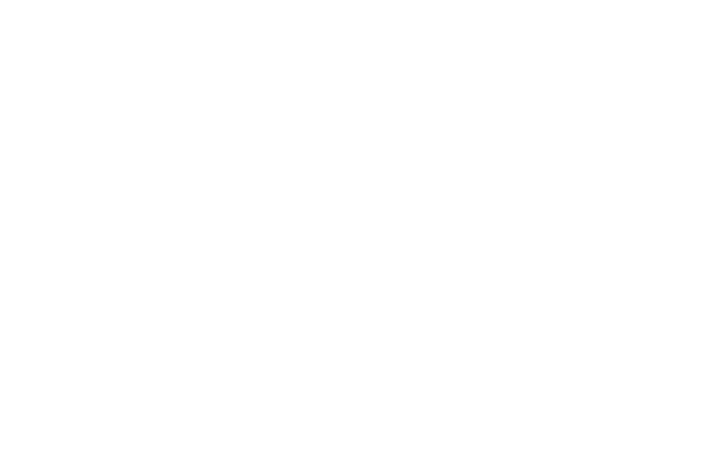

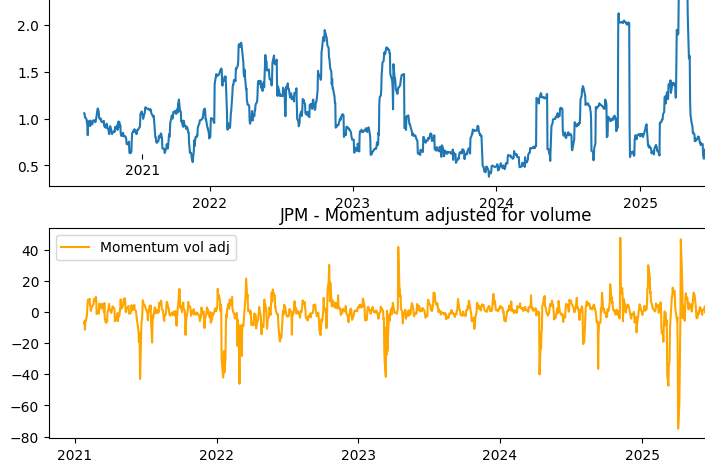

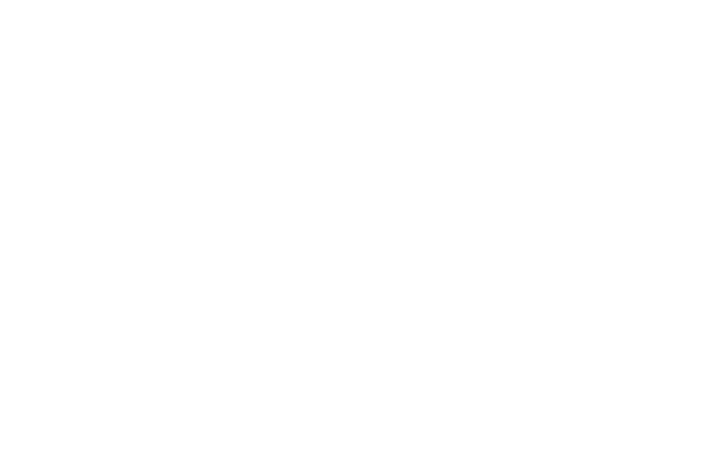

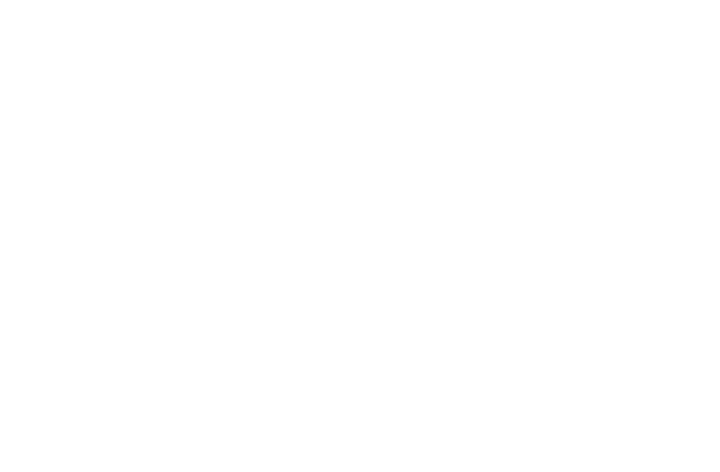

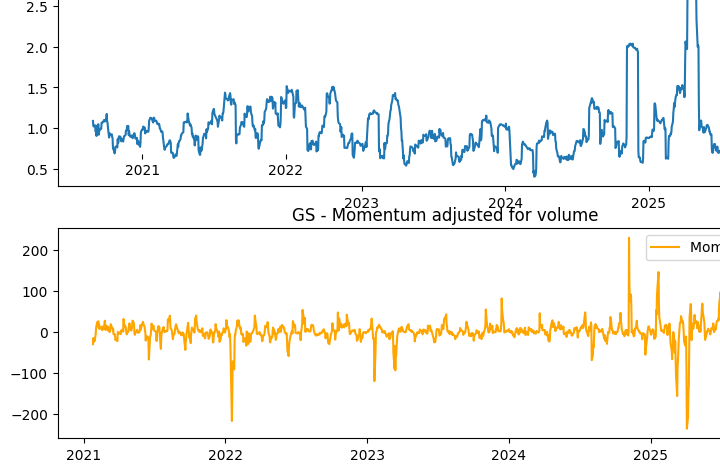

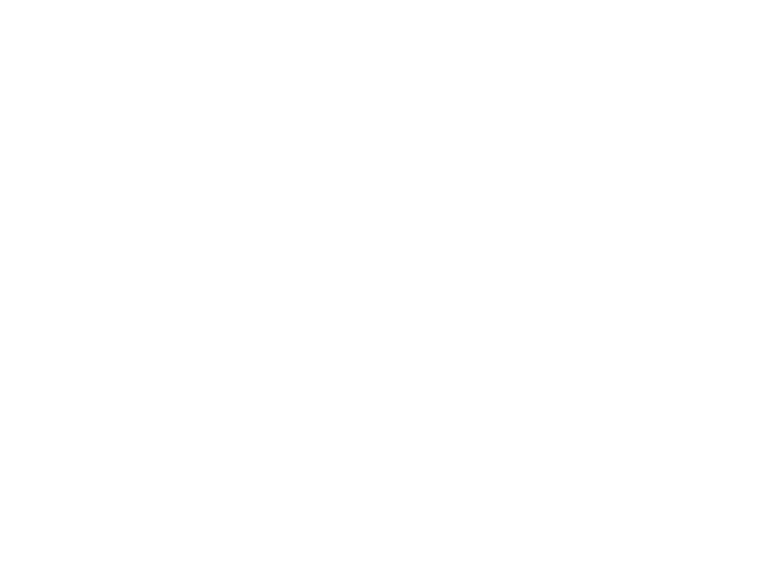

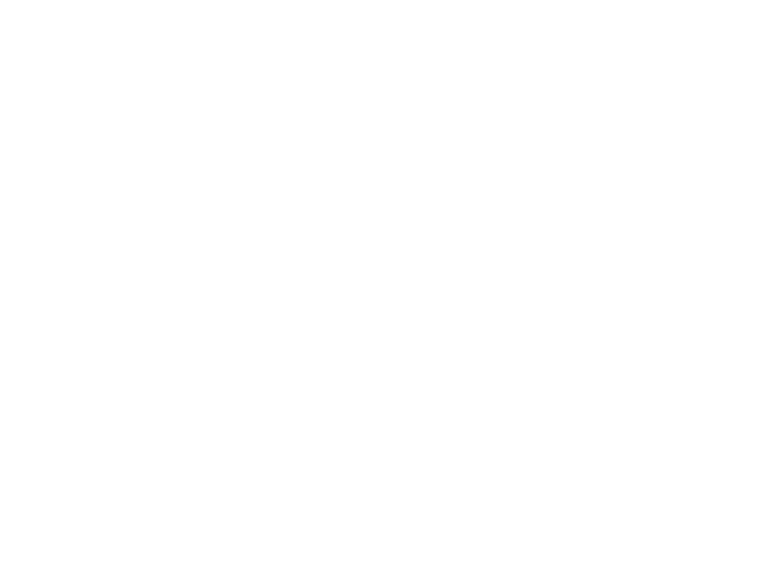

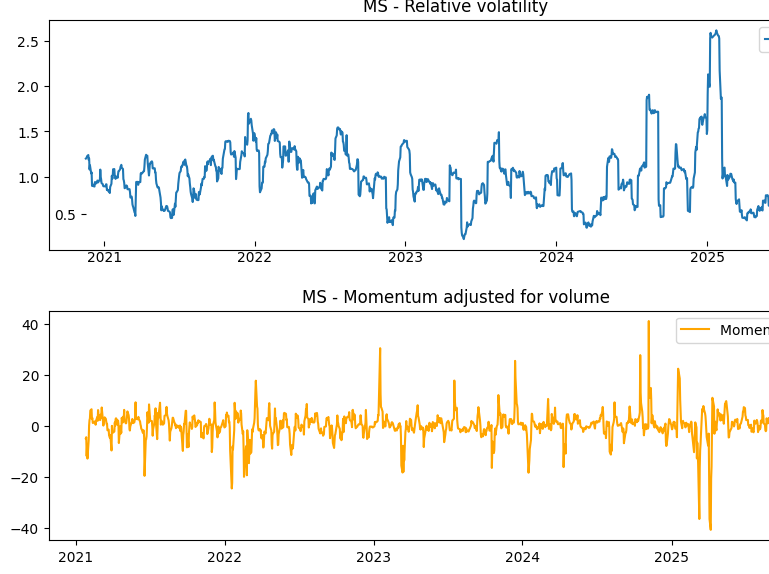

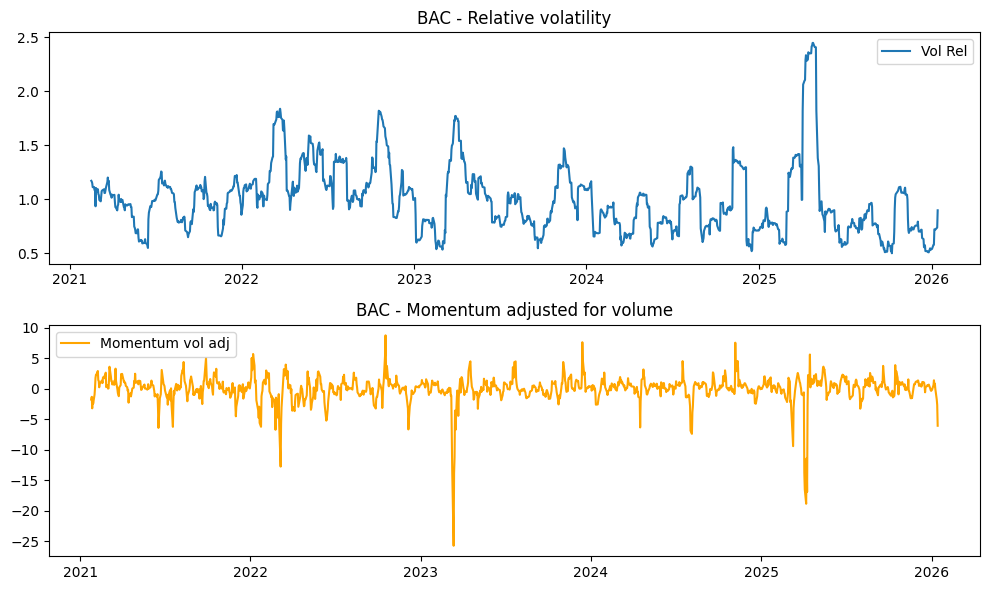

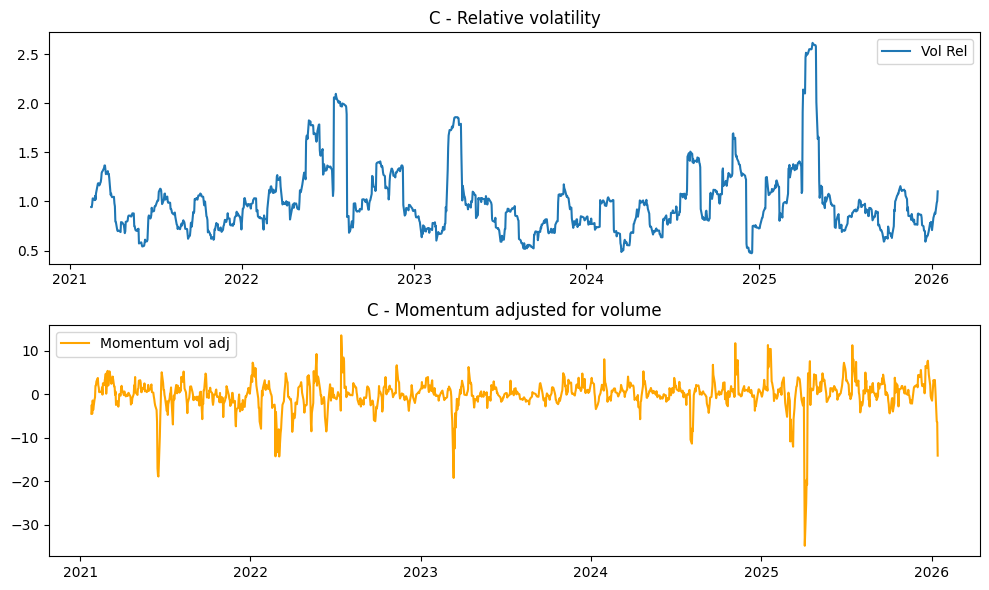

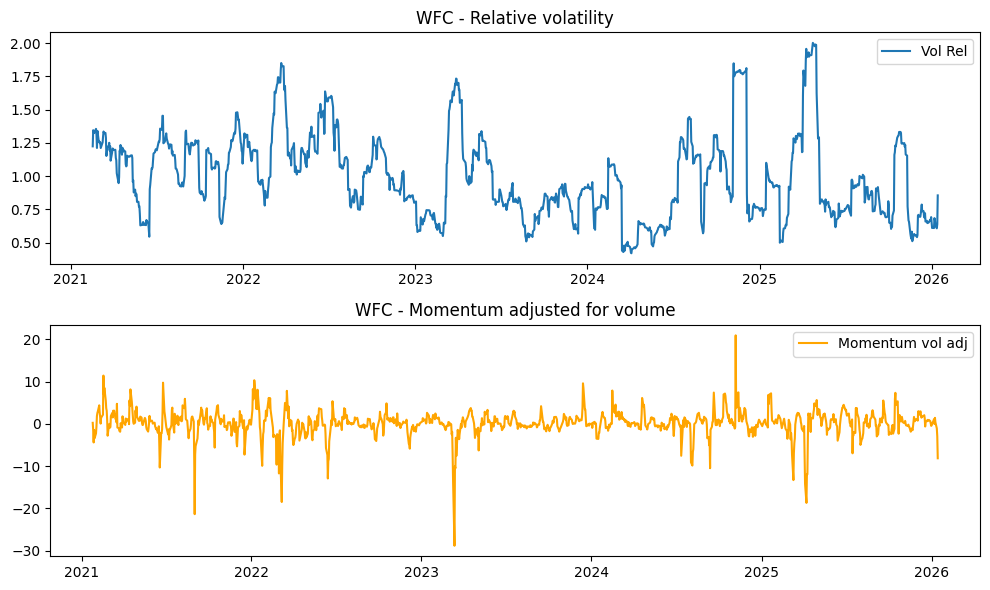

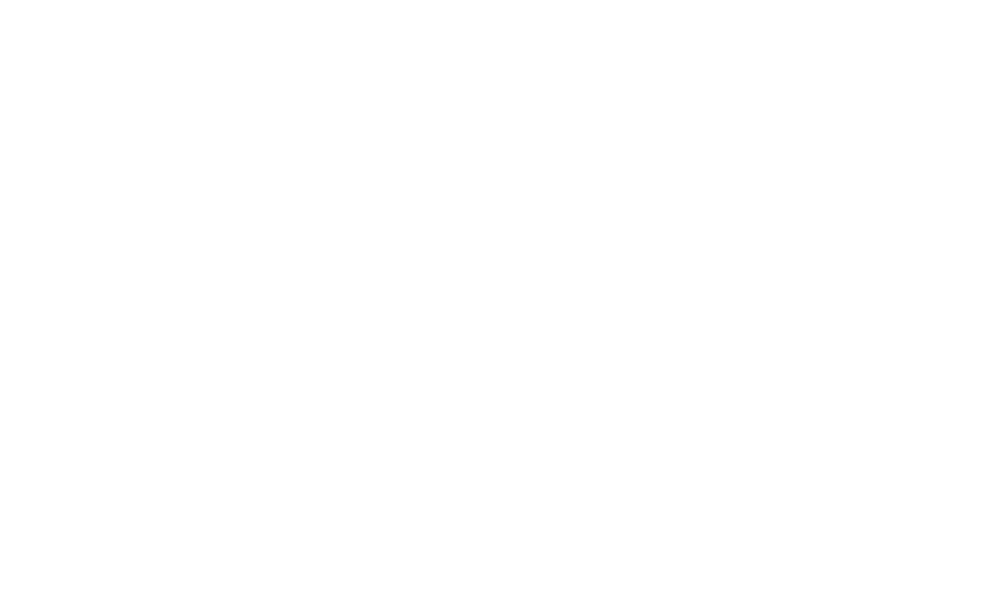

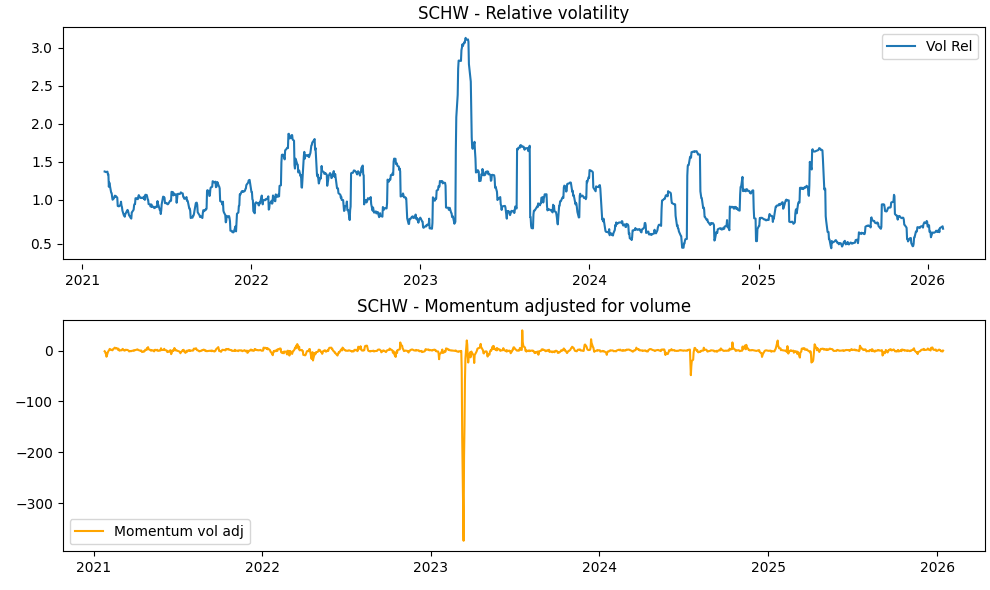

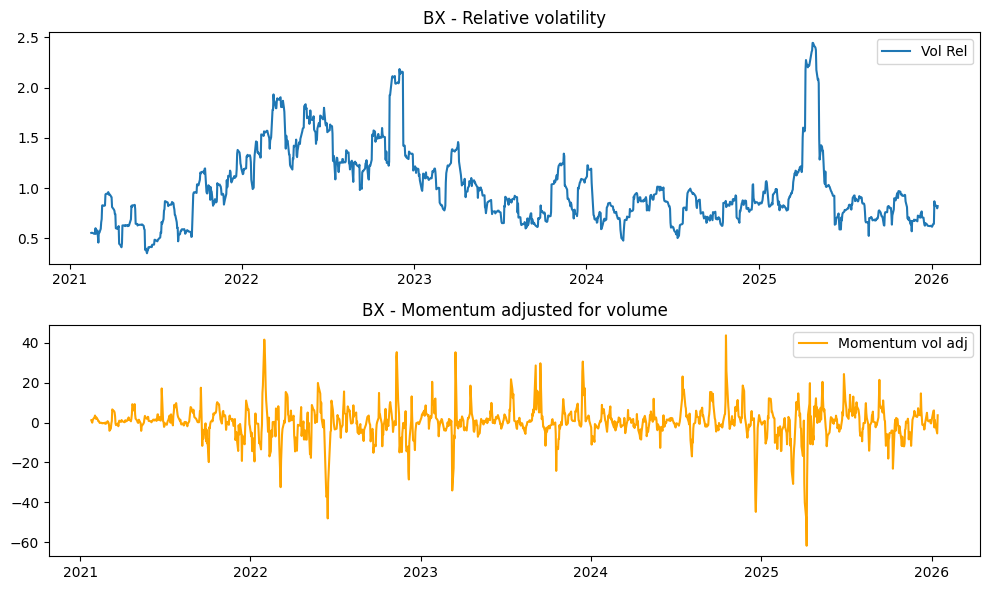

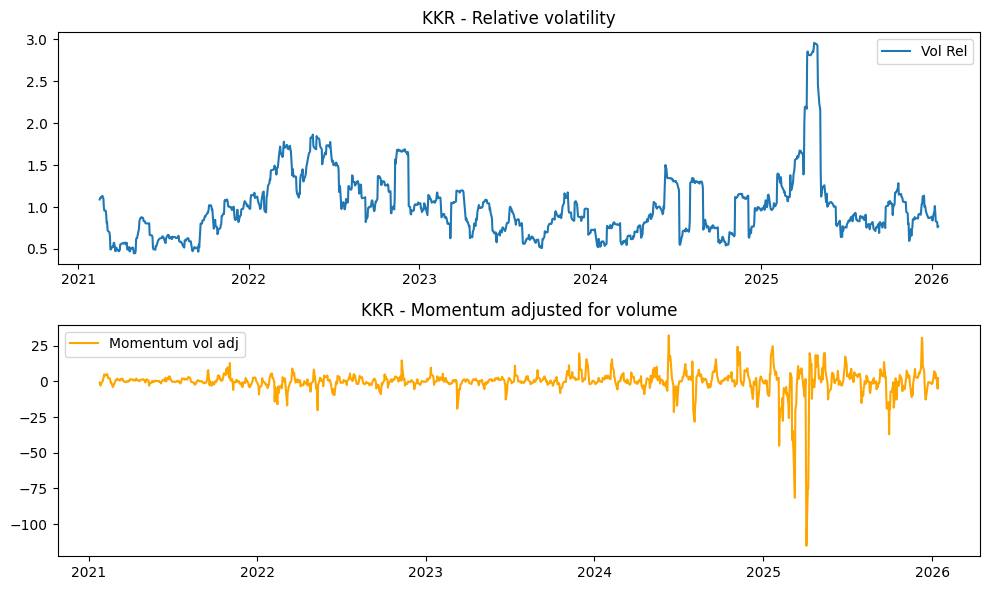

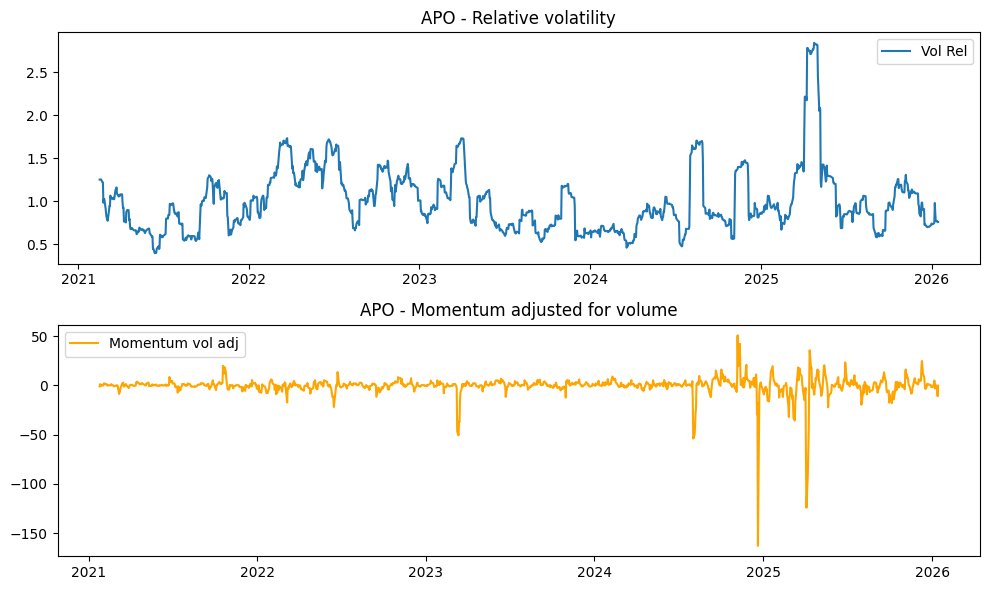

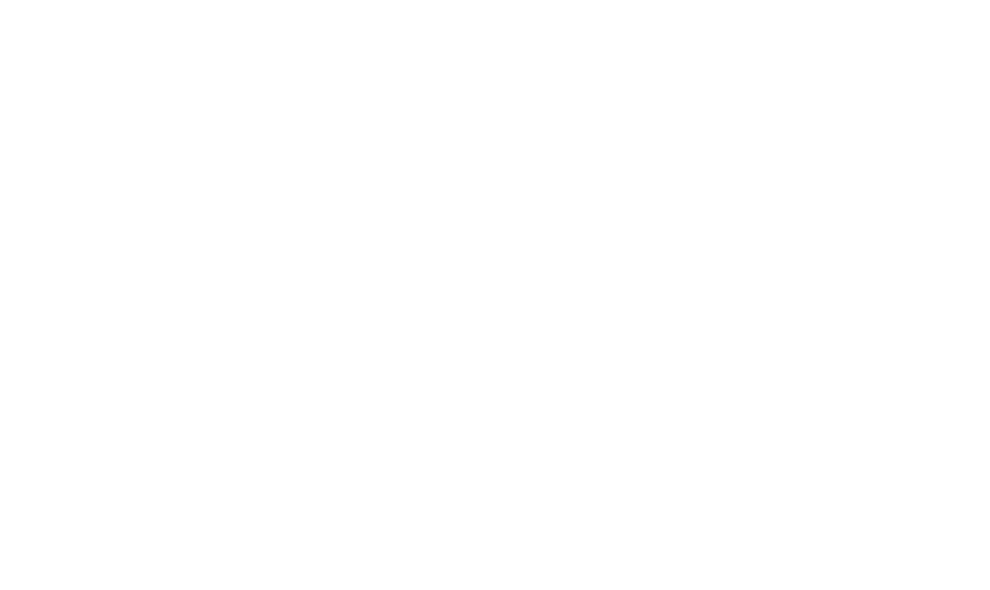

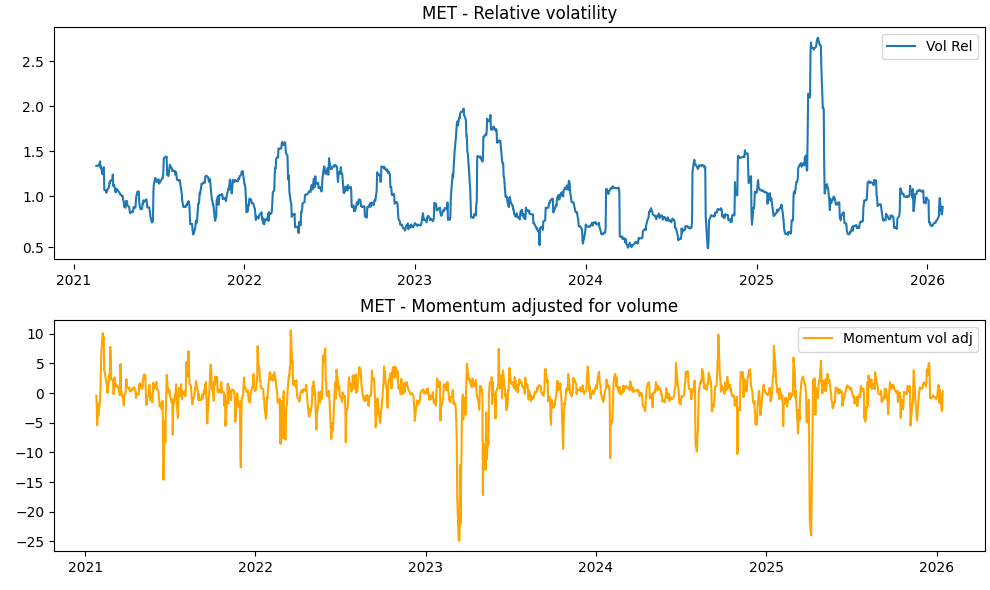

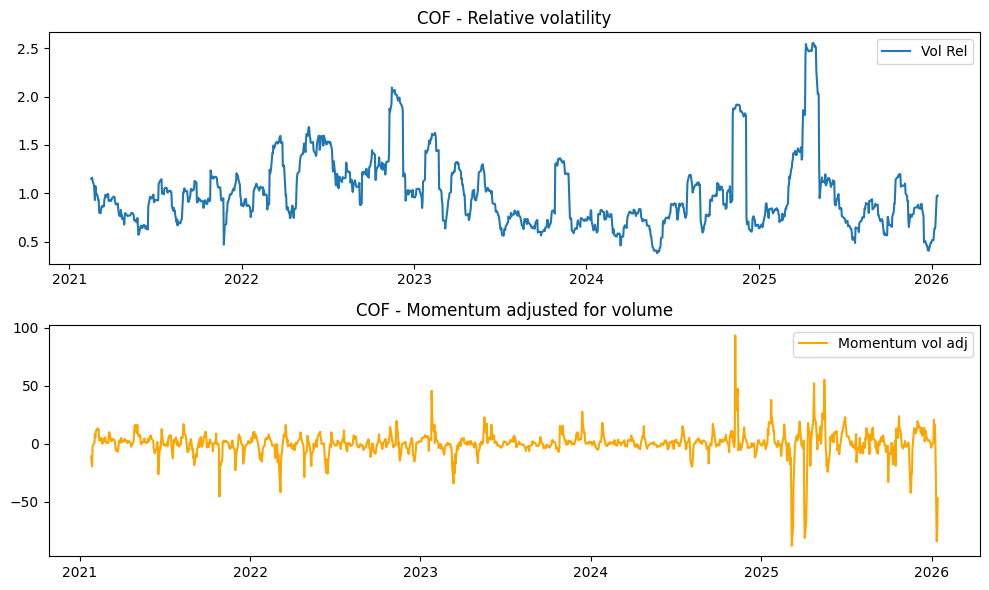

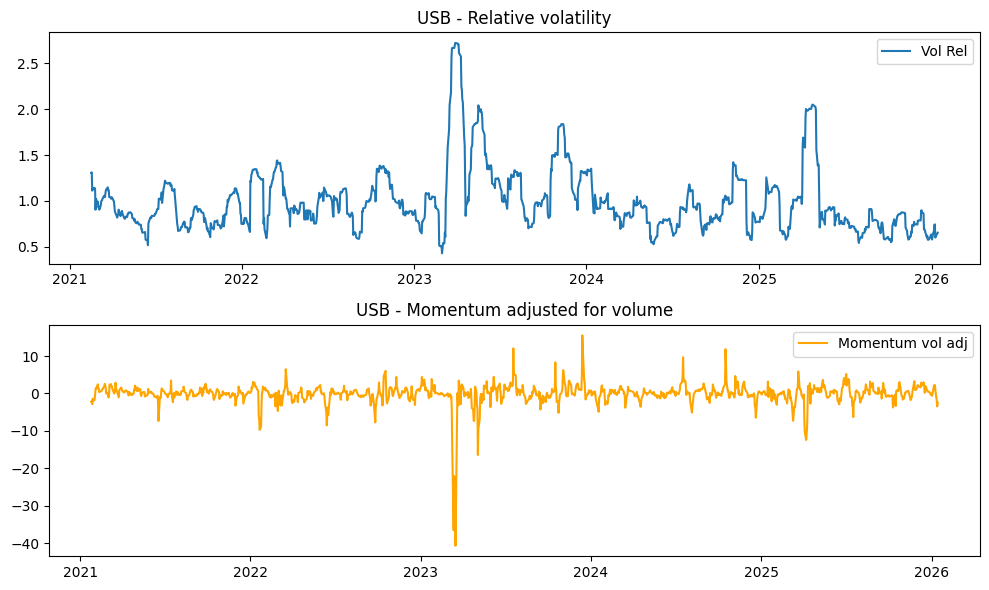

<Figure size 1000x600 with 0 Axes>

<Figure size 640x480 with 0 Axes>

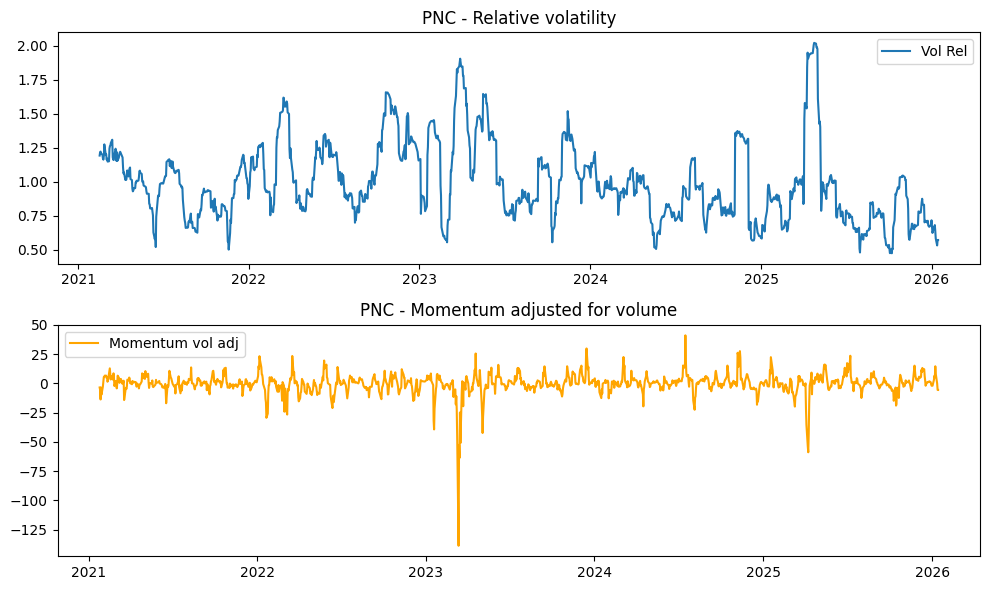

In [61]:
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

def plot_metrics(ticker):
  df = metrics[ticker]
  fig, ax = plt.subplots(2, 1, figsize=(10,6))
  ax[0].plot(df.index, df['volatility_relative'], label='Vol Rel')
  ax[0].set_title(f'{ticker} - Relative volatility')
  ax[0].legend()

  ax[1].plot(df.index, df['momentum_vol_adj'], label='Momentum vol adj', color='orange')
  ax[1].set_title(f'{ticker} - Momentum adjusted for volume')
  ax[1].legend()

  plt.tight_layout()
  plt.show()

with ThreadPoolExecutor(max_workers=3) as executor:
  executor.map(plot_metrics, tickers)


Which stocks have the strongest current signal

In [62]:
import heapq

latest_scores = []

for ticker, df in metrics.items():
  latest_value = df['momentum_vol_adj'].iloc[-1]
  # "-"" because Python uses min-heap
  # save value and name
  heapq.heappush(latest_scores, (-latest_value, ticker))

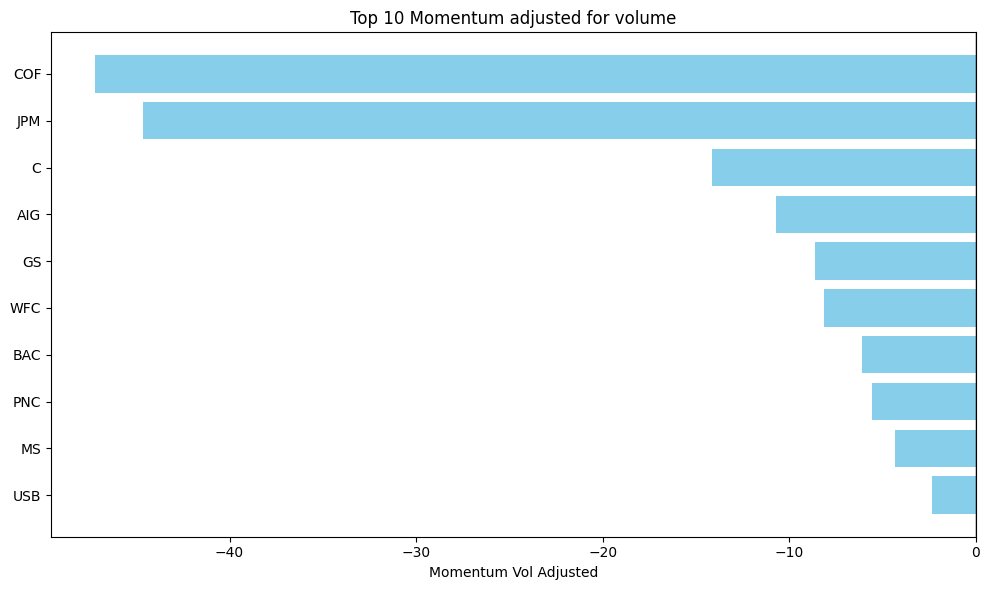

In [90]:
import matplotlib.pyplot as plt
import heapq

N = 10
top = heapq.nlargest(N, latest_scores)

tickers_top = [ticker for score, ticker in top]
scores_top = [-score for score, ticker in top]

plt.figure(figsize=(10, 6))
plt.barh(tickers_top, scores_top, color='skyblue')
plt.axvline(0, color='black', linewidth=1)
plt.xlabel("Momentum Vol Adjusted")
plt.title(f"Top {N} Momentum adjusted for volume")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Which stocks are behaving abnormally compared to their own history?

In [64]:
high_volatility = set()

for ticker, df in metrics.items():
  if df['volatility_relative'].iloc[-1] > 1.5:
    high_volatility.add(ticker)

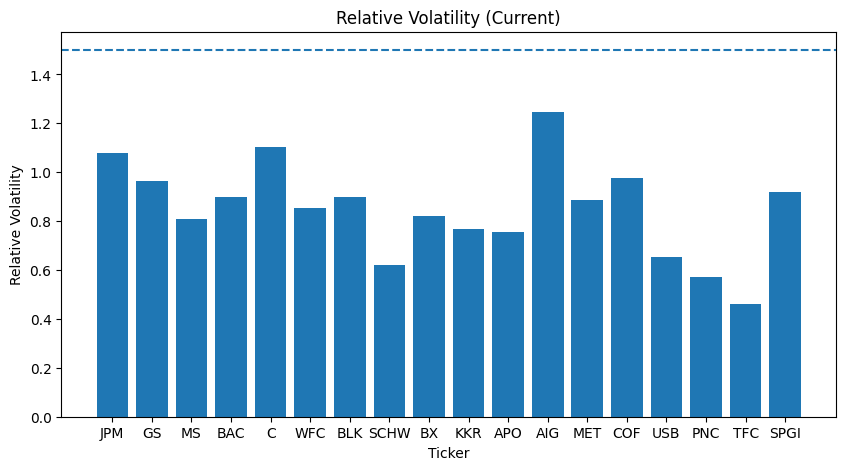

In [65]:
import matplotlib.pyplot as plt

tickers = []
values = []

for ticker, df in metrics.items():
  tickers.append(ticker)
  values.append(df['volatility_relative'].iloc[-1])

plt.figure(figsize=(10,5))
plt.bar(tickers, values)
plt.axhline(1.5, linestyle='--')
plt.title('Relative Volatility (Current)')
plt.xlabel('Ticker')
plt.ylabel('Relative Volatility')
plt.show()

How deep is the worst loss from a recent peak?

In [66]:
def max_drawdown(prices):
  stack = []
  max_dd = 0

  for price in prices:
    if not stack or price > stack[-1]:
      stack.append(price)
    else:
      drawdown = (stack[-1] - price / stack[-1])
      max_dd = max(max_dd, drawdown)

  return max_dd

In [79]:
drawdowns = {}

for ticker, df in metrics.items():
  prices = df['Adj Close'].values
  drawdowns[ticker] = max_drawdown(prices)


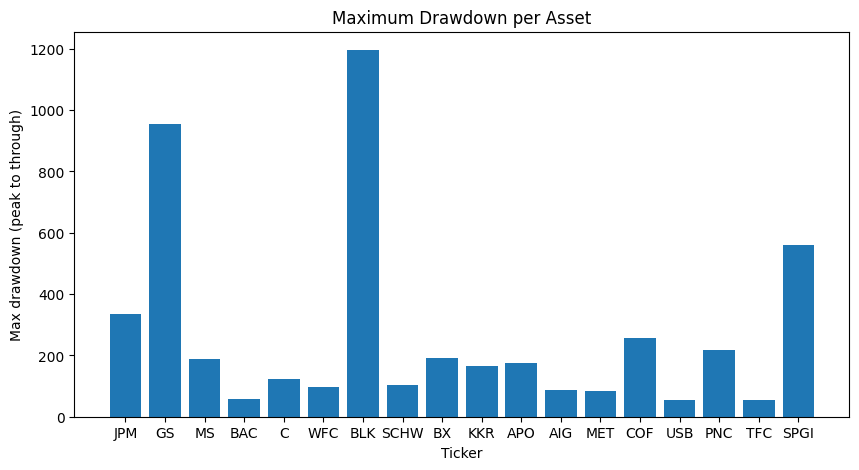

In [84]:
import matplotlib.pyplot as plt

tickers = list(drawdowns.keys())
values = list(drawdowns.values())
values_flat = [value.item() for value in values]

plt.figure(figsize=(10,5))
plt.bar(tickers, values_flat)
plt.title("Maximum Drawdown per Asset")
plt.ylabel("Max drawdown (peak to through)")
plt.xlabel("Ticker")
plt.show()